In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import datetime

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import json
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

from sklearn.preprocessing import MinMaxScaler
import joblib

from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from scipy.spatial import Delaunay

import itertools

In [3]:
sc_y = MinMaxScaler(feature_range=(0,1))
sc_x = MinMaxScaler(feature_range=(0,1))

In [6]:
dataset = pd.read_csv('/content/continuous_factory_process.csv')

In [8]:
dataset.head(3)

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage1.Output.Measurement5.U.Error,Stage1.Output.Measurement6.U.Error,Stage1.Output.Measurement7.U.Error,Stage1.Output.Measurement8.U.Error,Stage1.Output.Measurement9.U.Error,Stage1.Output.Measurement10.U.Error,Stage1.Output.Measurement11.U.Error,Stage1.Output.Measurement12.U.Error,Stage1.Output.Measurement13.U.Error,Stage1.Output.Measurement14.U.Error
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,2.74,0.43,0.03,0.48,2.22,0.59,0.62,0.36,0.47,3.21
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,2.74,0.28,2.97,1.65,2.21,1.10,1.03,0.98,0.46,17.72
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,2.74,0.28,2.97,1.65,2.21,1.10,1.03,0.98,0.46,17.72


In [7]:
cols=list(dataset.columns)
cols=cols[:72]

cols.remove("time_stamp")

y_cols=[]
for i in range(0,15):
    dataset[f"Stage1.Output.Measurement{i}.U.Error"]=dataset[f"Stage1.Output.Measurement{i}.U.Setpoint"]-dataset[f"Stage1.Output.Measurement{i}.U.Actual"]
    cols.remove(f"Stage1.Output.Measurement{i}.U.Setpoint")
    cols.remove(f"Stage1.Output.Measurement{i}.U.Actual")
    y_cols.append(f"Stage1.Output.Measurement{i}.U.Error")

In [9]:
X_cols=cols

In [10]:
def datatransformation(X,y,fit):
    if fit:
        X = sc_x.fit_transform(X)
        y = sc_y.fit_transform(y)
    else:
        X = sc_x.transform(X)
        y = sc_y.transform(y)

    X_ls = []
    y_ls = []
    for i in range(0, len(X)):
        X_ls.append(X[i])
        y_ls.append(y[i])

    X_arr, y_arr = np.array(X_ls), np.array(y_ls)
    X_arr = np.reshape(X_arr, (X_arr.shape[0], X_arr.shape[1]))

    return X_arr,y_arr

In [12]:
testlen=2000
trainlen=len(dataset.index)-testlen
dataset_train=dataset.head(trainlen)
dataset_test=dataset.tail(testlen)


In [13]:
X_train=dataset_train[X_cols].values
y_train=dataset_train[y_cols].values
X_test=dataset_test[X_cols].values
y_test=dataset_test[y_cols].values

In [14]:
X_train_batches,y_train_batches=datatransformation(X_train,y_train,True)
X_test_batches,y_test_batches=datatransformation(X_test,y_test,False)

In [15]:
model = Sequential()

model.add(Dense(64,activation='relu',input_shape=(X_train_batches.shape[1],)))
model.add(Dense(32,activation='relu'))
model.add(Flatten())
model.add(Dense(y_train_batches.shape[1]))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2688      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
Total params: 5,263
Trainable params: 5,263
Non-trainable params: 0
_________________________________________________________________


In [16]:
crossvalidation_err=[]
totalepochs=0
epochsperiter=10


startepochs=10
firstepoch=True
for i in range(10):

    if firstepoch:
        train_err=model.fit(X_train_batches,y_train_batches,epochs=startepochs,steps_per_epoch=32)
        totalepochs+=startepochs
        firstepoch=False
    else:
        train_err=model.fit(X_train_batches,y_train_batches,epochs=epochsperiter,steps_per_epoch=32)
        totalepochs+=epochsperiter

    test_err=model.evaluate(X_test_batches,y_test_batches)
    newrecord=[totalepochs,train_err.history["loss"][-1],test_err,model]
    crossvalidation_err.append(newrecord)

Epoch 1/10
32/32 [==============================] - 2s 2ms/step - loss: 0.1737
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 1/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 3/10
32/32 [==============================] -

In [17]:
epochs=[i[0] for i in crossvalidation_err]
trainerr=[i[1] for i in crossvalidation_err]
testerr=[i[2] for i in crossvalidation_err]

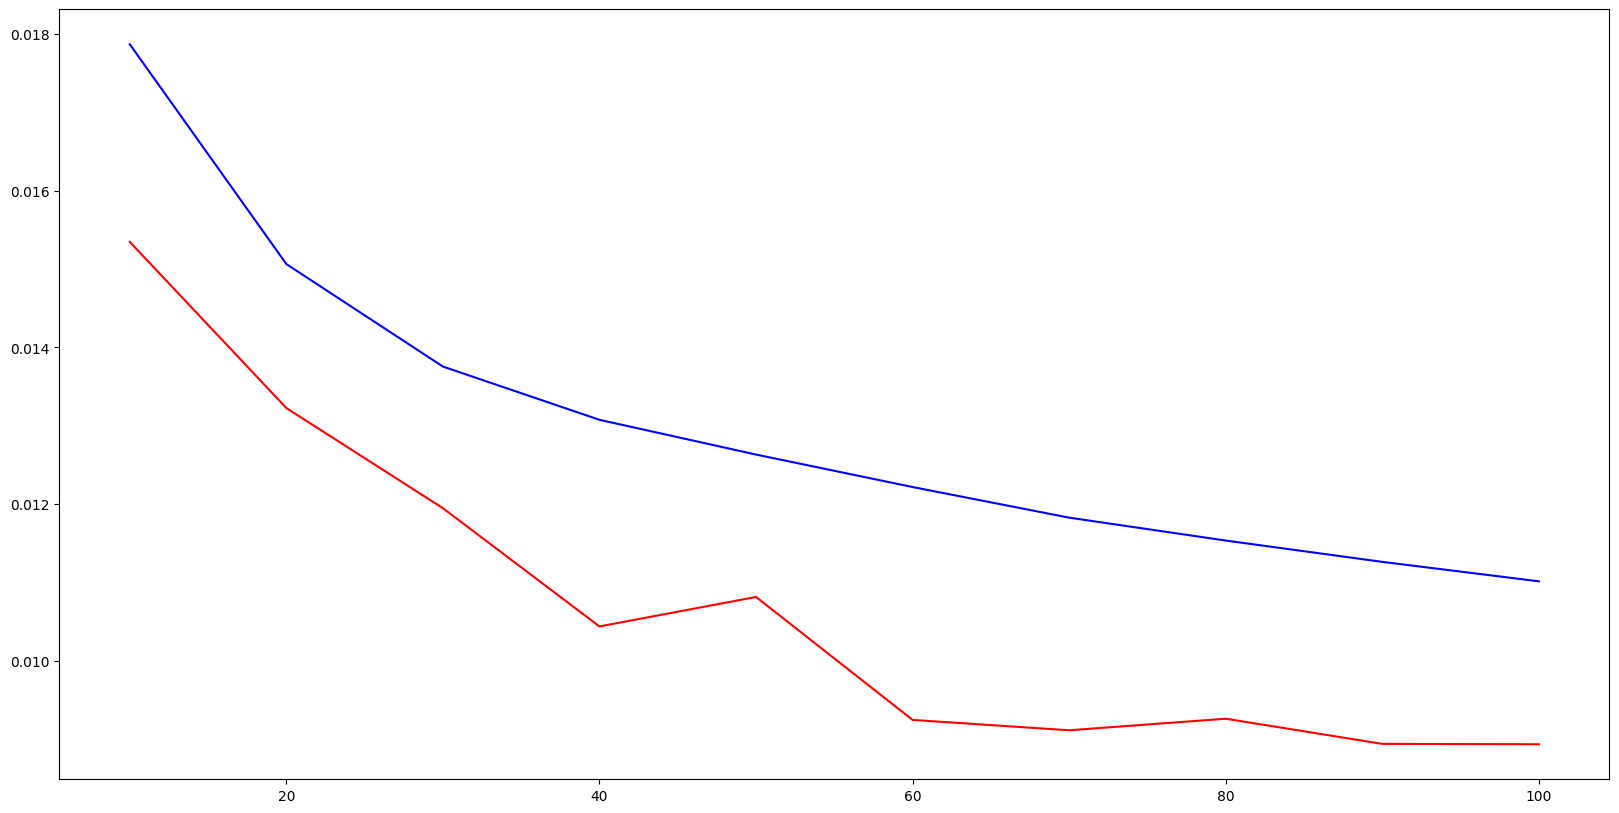

In [18]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(epochs,trainerr, color = 'blue')
plt.plot(epochs,testerr,color="red")

In [19]:
ls_mean=dataset[X_cols].mean(axis=0).values
ls_max=dataset[X_cols].max(axis=0).values
ls_min=dataset[X_cols].min(axis=0).values

ls_counterfactual=dataset[X_cols].mean(axis=0).values

In [20]:
@widgets.interact_manual(
    column=X_cols, new=(0,2000))
def plot(column=X_cols[0], new=1):
    ls_counterfactual[X_cols.index(column)]=new

    print("max",ls_max[X_cols.index(column)])
    print("mean",ls_mean[X_cols.index(column)])
    print("min",ls_min[X_cols.index(column)])

    print("current",ls_counterfactual[X_cols.index(column)])

interactive(children=(Dropdown(description='column', options=('AmbientConditions.AmbientHumidity.U.Actual', 'A…

In [21]:
X_counter_factual = sc_x.transform(X_test_batches)
prediction=model.predict(X_counter_factual)
inverted_pred=sc_y.inverse_transform(prediction)

63/63 [==============================] - 0s 1ms/step


In [22]:
X_cols

['AmbientConditions.AmbientHumidity.U.Actual',
 'AmbientConditions.AmbientTemperature.U.Actual',
 'Machine1.RawMaterial.Property1',
 'Machine1.RawMaterial.Property2',
 'Machine1.RawMaterial.Property3',
 'Machine1.RawMaterial.Property4',
 'Machine1.RawMaterialFeederParameter.U.Actual',
 'Machine1.Zone1Temperature.C.Actual',
 'Machine1.Zone2Temperature.C.Actual',
 'Machine1.MotorAmperage.U.Actual',
 'Machine1.MotorRPM.C.Actual',
 'Machine1.MaterialPressure.U.Actual',
 'Machine1.MaterialTemperature.U.Actual',
 'Machine1.ExitZoneTemperature.C.Actual',
 'Machine2.RawMaterial.Property1',
 'Machine2.RawMaterial.Property2',
 'Machine2.RawMaterial.Property3',
 'Machine2.RawMaterial.Property4',
 'Machine2.RawMaterialFeederParameter.U.Actual',
 'Machine2.Zone1Temperature.C.Actual',
 'Machine2.Zone2Temperature.C.Actual',
 'Machine2.MotorAmperage.U.Actual',
 'Machine2.MotorRPM.C.Actual',
 'Machine2.MaterialPressure.U.Actual',
 'Machine2.MaterialTemperature.U.Actual',
 'Machine2.ExitZoneTemperature.

In [24]:
# finding optimal parameters for combiner
gridparams=["FirstStage.CombinerOperation.Temperature1.U.Actual",
            "FirstStage.CombinerOperation.Temperature2.U.Actual",
            "FirstStage.CombinerOperation.Temperature3.C.Actual"]

# finding optimal parameters for Machine 1
gridparams=["Machine1.Zone1Temperature.C.Actual",
            "Machine1.ExitZoneTemperature.C.Actual",
            "Machine1.MaterialTemperature.U.Actual"]

# finding optimal temperature for materials
gridparams=["Machine1.MaterialTemperature.U.Actual",
            "Machine2.MaterialTemperature.U.Actual",
            "Machine3.MaterialTemperature.U.Actual"]

# searching through
gridparams=['Machine1.RawMaterial.Property1',
 'Machine1.RawMaterial.Property2',
 'Machine1.RawMaterial.Property3',
 'Machine1.RawMaterial.Property4',
 'Machine1.RawMaterialFeederParameter.U.Actual',
 'Machine1.Zone1Temperature.C.Actual',
 'Machine1.Zone2Temperature.C.Actual',
 'Machine1.MotorAmperage.U.Actual',
 'Machine1.MotorRPM.C.Actual',
 'Machine1.MaterialPressure.U.Actual',
 'Machine1.MaterialTemperature.U.Actual']

In [25]:
gridinterval=[]
numberofpoints=4
for i in gridparams:
    parammin=dataset[i].min(axis=0)*.8
    parammax=dataset[i].max(axis=0)*1.2

    gridinterval.append(np.linspace(parammin,parammax,numberofpoints).tolist())

In [26]:
print("No of simulations",numberofpoints**len(gridparams))

No of simulations 4194304


In [27]:
param_combinations=[]
for i in itertools.product(*gridinterval):
    param_combinations.append(i)

In [28]:
ls_counterfactual_base=dataset[X_cols].mean(axis=0).values

ls_counterfactual_records=[]

for param_combination in param_combinations:
    i=0
    ls_counterfactual_temp=ls_counterfactual_base
    for param in param_combination:
        ls_counterfactual_temp[X_cols.index(gridparams[i])]=param
        i+=1

    ls_counterfactual_records.append(ls_counterfactual_temp.copy())

In [29]:
np_counterfactual_records=np.array(ls_counterfactual_records)
X_counterfactual_records = sc_x.transform(np_counterfactual_records)
prediction=model.predict(X_counterfactual_records)
inverted_pred=sc_y.inverse_transform(prediction)

131072/131072 [==============================] - 194s 1ms/step


In [30]:
df_pred=pd.DataFrame(inverted_pred,columns=y_cols)
df_pred["Error"]=df_pred[y_cols].abs().sum(axis=1)
df_feature=pd.DataFrame(np_counterfactual_records,columns=X_cols)
df_prediction=df_feature.join(df_pred)

In [31]:
# plotting all combinations of variables
for i in [(0,1),(0,2),(1,2)]:
    axes=[gridparams[i[0]],gridparams[i[1]]]
    plotvals=df_prediction.drop_duplicates(subset=axes).pivot(index=axes[0], columns=axes[1], values=["Error"]).copy()
    ploty=[i[1] for i in plotvals.columns.tolist()]
    plotx=plotvals.index
    plotz=plotvals.values

    fig = go.Figure(data=[go.Surface(z=plotz, x=plotx, y=ploty)])

    fig.update_scenes(zaxis_title_text='Deviation')

    fig.add_annotation(dict(font=dict(size=10),
                                            x=0,
                                            y=1,
                                            showarrow=False,
                                            text=f'x:{axes[0]} <br> y:{axes[1]}',
                                            textangle=0,
                                            xanchor='left',
                                            xref="paper",
                                            yref="paper"))


    fig.show()

In [32]:
min_loc=df_prediction["Error"].idxmin()
improvement=dataset[y_cols].abs().sum(axis=1).mean()-df_prediction.iloc[min_loc,:]["Error"]
print("potential error:",df_prediction.iloc[min_loc,:]["Error"])
print("potential improvement:",improvement)
print("potential improvement%:",(improvement/dataset[y_cols].abs().sum(axis=1).mean())*100)
print("_____________")
print("current mean values")
print("running with parameters")
print(dataset[gridparams].mean())
print("_____________")
print("running with parameters")
print(df_prediction.iloc[min_loc,:][gridparams])
print("_____________")
print("change in parameters")
print(dataset[gridparams].mean()-df_prediction.iloc[min_loc,:][gridparams])

potential error: 77.6649398803711
potential improvement: -33.79549537979884
potential improvement%: -77.0365245435419
_____________
current mean values
running with parameters
Machine1.RawMaterial.Property1                    11.851256
Machine1.RawMaterial.Property2                   205.676320
Machine1.RawMaterial.Property3                   951.679815
Machine1.RawMaterial.Property4                   248.868896
Machine1.RawMaterialFeederParameter.U.Actual    1242.764276
Machine1.Zone1Temperature.C.Actual                72.013330
Machine1.Zone2Temperature.C.Actual                72.013106
Machine1.MotorAmperage.U.Actual                   70.333111
Machine1.MotorRPM.C.Actual                        11.072094
Machine1.MaterialPressure.U.Actual               409.006724
Machine1.MaterialTemperature.U.Actual             81.470000
dtype: float64
_____________
running with parameters
Machine1.RawMaterial.Property1                   13.397333
Machine1.RawMaterial.Property2                  283.